* The code in this file implements the randomized svd based on the pseudocodes of the rsvd library.
* The rsvd library and its write up can be found at: https://github.com/erichson/rSVD and https://arxiv.org/pdf/1608.02148.pdf

In [20]:
import pandas as pandas
import random as rd
import numpy as np
import matplotlib.pyplot as plt
import time

# Generating the Matrix A

* We aim to generate Matrix $A$ with a specified singular values.
    1. We generate $A = UPV$, where $U$ and $V$ are random matrices.
    2. $U$ and $V$ have very high chance of being full rank due to the probability.
    3. Entries of P is same as the singular values of $A$. Order can be different.
    4. It is very important to use $QR$ to $U$ and $V$ before multiplying $U,P,V$
    5. Below example generates $P$ with a gradual decay.

[[-0.00638586  0.00137939  0.0016804  ...  0.0019507   0.00367421
  -0.00498691]
 [ 0.00677263  0.00164338 -0.00391836 ...  0.00811763  0.0005812
  -0.0006036 ]
 [ 0.00085965 -0.00116095  0.00400565 ... -0.00035472 -0.00174063
  -0.00103976]
 ...
 [-0.00359649 -0.0016627   0.00082195 ... -0.00093713  0.00349481
   0.00707074]
 [ 0.00022888 -0.00076532  0.00146287 ...  0.0021074  -0.00408379
  -0.00284989]
 [ 0.00547367 -0.00341624  0.0028419  ...  0.00103211  0.0021436
  -0.00077127]]


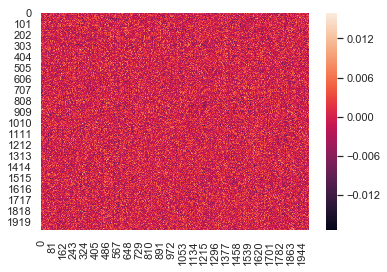

In [21]:
# A is mxn and rank k.
# Diagonal entries of P is same as the singular values of A.
# numpy.random.rand() has uniform continuous distribution on [0,1]
m,n,k = 2000,2000,120
randU = np.random.rand(m,m)
randV = np.random.rand(n,n)

# If you don't use QR and then multiply, there will be one large singular value.
# Using QR gives us same singular value for A as P
randU, r = np.linalg.qr(randU)
randV, r = np.linalg.qr(randV)

# numpy.random.random() has uniform continuous distribution on [0,1]
sig = np.random.random(k)
sig = np.asarray(sig.tolist() + (np.zeros(m-k)).tolist())
P = np.diag(sig)

# matmul is quite slow...
A = np.matmul(randU,P) #You can't just use *!!! You have to use matmul function.
A = np.matmul(A,randV)
print(A) 

import seaborn as sns; sns.set()
ax = sns.heatmap(A)

# rsvd implementation in python

* Step1: compute $Q$  used in $A\approx Q Q^T A = QB$
    1. Generate Random Matrix $\Omega$
    2. Preprocess $A$ to $A^{(q)} := (AA^T)^{(q)}A$
    3. Apply QR-decomp to $Y:=A\Omega = QR$
         * number 2 and 3 are done simultaneously

In [22]:
# Generate Random Matrix Omega(nxk)
q = 2 # Preprocessing (page 9 of the write up of rsvd) for better computation, applied later with Y
k = 30 # How many random vectors you want to use -> changes the size of Omega.
p = 10 # OverSampling
l = k+p # l is lowercase L
n = len(A) # column number of A
Omega = []
for i in list(range(0,l)):
    w = (np.random.random(n)) # n is the column number of A
    Omega.append(w)
print(Omega) # Omega is a collection of k+p random vectors
Omega = np.column_stack(Omega) # Merge all k+p vectors into a matrix Omega.
print(Omega)

[array([0.21593794, 0.04135023, 0.22426941, ..., 0.78771115, 0.20550523,
       0.03956579]), array([0.23551011, 0.06031091, 0.28039603, ..., 0.51310091, 0.32326026,
       0.26220402]), array([0.19948337, 0.94421558, 0.3572336 , ..., 0.78918773, 0.65663078,
       0.09825695]), array([0.40106635, 0.95192746, 0.96716191, ..., 0.27860847, 0.43172865,
       0.24769681]), array([0.6007631 , 0.4754572 , 0.59492799, ..., 0.47992464, 0.26171234,
       0.78514953]), array([0.09475949, 0.31307131, 0.32460474, ..., 0.01920693, 0.60249822,
       0.30899005]), array([0.01958508, 0.61789633, 0.33604753, ..., 0.56307614, 0.86372577,
       0.60340606]), array([0.57963313, 0.91118726, 0.13859515, ..., 0.50784023, 0.79160385,
       0.46674864]), array([0.65831015, 0.73061003, 0.69632192, ..., 0.08791257, 0.11090876,
       0.99678725]), array([0.69144079, 0.38585307, 0.65430593, ..., 0.0794381 , 0.05122486,
       0.16171995]), array([0.33648564, 0.2616614 , 0.01630299, ..., 0.21249632, 0.6549970

In [23]:
# Apply QR-decomp to A*Omega with preprocess amount q (refer to page 9 in the write up by Erichson)
Y = np.matmul(A,Omega)
for i in list(range(0,q)):
    Q, R = np.linalg.qr(Y)
    Q, R = np.linalg.qr(np.matmul(np.transpose(A), Q))
    Y = np.matmul(A,Q)
Q, R = np.linalg.qr(Y)

* Step2: $A \approx QQ^{T}A = QB = Q\hat{U}\Sigma V^{T} = U\Sigma V^{T}$

In [24]:
# Apply traditional svd on B and gain approx svd for A
B = np.matmul(np.transpose(Q),A)
U_hat, S, V_t = np.linalg.svd(B)
U = np.matmul(Q,U_hat)
# Now svd for A is approximately U, S, V_t

* Now, we can calculate true svd and compare.

In [25]:
# True SVD of A
U2,S2,V2 = np.linalg.svd(A)

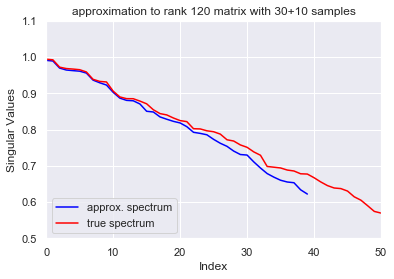

In [26]:
plt.plot(S,color = "blue",label='approx. spectrum')
plt.plot(S2,color="red",label='true spectrum')
plt.xlim(0,50)
plt.ylim(0.5,1.1)
plt.title("approximation to rank 120 matrix with 30+10 samples")
plt.xlabel("Index")
plt.ylabel("Singular Values")
plt.legend(loc='lower left')
plt.show()

In [27]:
# Difference in size of the approximated spectrum and the true spectrum. It is very small.
concS2 = S2[:40]
diff = np.linalg.norm(concS2-S)
print(diff)

0.12828179478554533


* Below is the function version of rsvd
    * Keep the default parameters in mind

In [29]:
np.random.random(len(A))

array([0.35338029, 0.03704875, 0.91520814, ..., 0.00430982, 0.75105228,
       0.4053241 ])

In [31]:
np.random.choice(10,100)

array([3, 3, 4, 9, 3, 7, 2, 2, 3, 4, 4, 6, 4, 7, 6, 7, 0, 9, 5, 0, 7, 3,
       7, 1, 4, 7, 1, 4, 5, 4, 0, 5, 7, 7, 3, 7, 0, 5, 8, 1, 4, 2, 4, 8,
       8, 5, 9, 1, 9, 8, 8, 7, 8, 7, 0, 3, 2, 1, 1, 7, 7, 2, 4, 4, 4, 0,
       5, 5, 7, 3, 5, 1, 3, 4, 4, 2, 9, 9, 8, 7, 0, 6, 3, 1, 5, 4, 7, 3,
       4, 3, 4, 7, 7, 9, 4, 2, 1, 4, 8, 3])

In [37]:
# @ A input matrix
# @ q preprocessing amount
# @ k sample amount
# @ p oversample amount
def rsvd(A,q=2,k=30,p=10):
    l = k+p
    n = len(A)
    Omega = []
    for i in list(range(0,l)):
        w = np.random.random(n) # len(A) should be column number of A
        Omega.append(w)
    Omega = np.column_stack(Omega)
    Y = np.matmul(A,Omega)
    for i in list(range(0,q)):
        Q, R = np.linalg.qr(Y)
        Q, R = np.linalg.qr(np.matmul(np.transpose(A), Q))
        Y = np.matmul(A,Q)
    Q, R = np.linalg.qr(Y)
    B = np.matmul(np.transpose(Q),A)
    U_hat, S, V_t = np.linalg.svd(B)
    U = np.matmul(Q,U_hat)
    return U, S, V_t

# Diverse Insights

* Power of Preprocessing
    * Decay in spectrum for preprocessed and non-preprocessed matrices (page 8 of rsvd write up by Erichson)
    * The result evidently shows that the decay gets faster with preprocessing.
    * This means that the data A becomes better for approximating

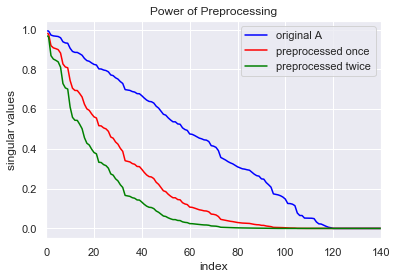

In [38]:
# True Spectrum vs Preprocessed Spectrum
U2,S2,V2 = np.linalg.svd(A)
AAT = np.matmul(A,np.transpose(A))
A_1 = np.matmul(AAT,A)
U3,S3,V3 = np.linalg.svd(A_1)
A_2 = np.matmul(AAT,A_1)
U4,S4,V4 = np.linalg.svd(A_2)

plt.plot(S2,color = "blue",label='original A')
plt.plot(S3,color="red",label='preprocessed once')
plt.plot(S4,color="green", label='preprocessed twice')
plt.title('Power of Preprocessing')
plt.xlim(0,140)
plt.xlabel('index')
plt.ylabel('singular values')
plt.legend(loc='upper right')
plt.show()

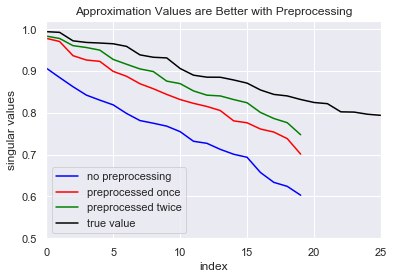

In [39]:
# p is a place holder here
p,s1,p = rsvd(A,q=0,k=10)
p,s2,p = rsvd(A,q=1,k=10)
p,s3,p = rsvd(A,q=2,k=10)
p,s4,p = np.linalg.svd(A)
plt.plot(s1,color="blue",label='no preprocessing')
plt.plot(s2,color="red",label='preprocessed once')
plt.plot(s3,color="green",label='preprocessed twice')
plt.plot(s4,color="black", label='true value')
plt.xlim(0,25)
plt.ylim(0.5, 1.02)
plt.title('Approximation Values are Better with Preprocessing')
plt.xlabel('index')
plt.ylabel('singular values')
plt.legend(loc='lower left')
plt.show()

* Sampling amount and Oversampling
    * More sampling means more stable
    * Oversampling by few more helps a lot

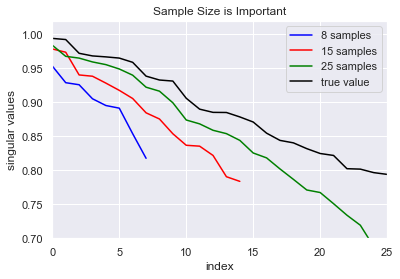

In [40]:
# p is a place holder here. set oversampling to 0
p,s1,p = rsvd(A,k=8,p=0)
p,s2,p = rsvd(A,k=15,p=0)
p,s3,p = rsvd(A,k=25,p=0)
#p,s4,p = np.linalg.svd(A) #calculated from before
plt.plot(s1,color="blue",label='8 samples')
plt.plot(s2,color="red",label='15 samples')
plt.plot(s3,color="green",label='25 samples')
plt.plot(s4,color="black", label='true value')
plt.xlim(0,25)
plt.ylim(0.7,1.02)
plt.title('Sample Size is Important')
plt.xlabel('index')
plt.ylabel('singular values')
plt.legend(loc='upper right')
plt.show()

* Sparsity of a Matrix

* Spectral Decay of a Matrix

# Time Comparison

In [13]:
import time

In [14]:
#### normal svd

start = time.time()
U2,S2,V2 = np.linalg.svd(A)
end = time.time()

print(end-start)

6.572836875915527


In [15]:
#### rsvd with q=2 k=30 => 10 times faster than normal svd

start = time.time()
u,s,v = rsvd(A,q=2,k=30)
end = time.time()

print(end-start)

0.8183844089508057


# Consideration & Discussion

* Difference in Computing for rapid decaying spectrum and slow decaying spectrum
* Difference in Computing for Sparsity of a Matrix

* research idea: Changing algorithms according to the shape and sparsity of a matrix?

* Why is there only a single large singular value for non-orthogonalized U and V?

In [45]:
# Generate A with non orthogonalized U and V
m,n,k = 2000,2000,120
randU = np.random.rand(m,m)
randV = np.random.rand(n,n)
sig = np.random.random(k)
sig = np.asarray(sig.tolist() + (np.zeros(m-k)).tolist())
P = np.diag(sig)
A = np.matmul(randU,P)
A = np.matmul(A,randV)
print(A) 

[[16.09812349 16.88221938 16.20581866 ... 16.22052176 15.67474942
  17.50117536]
 [14.52069813 16.07291149 16.12411878 ... 16.32168038 15.61867412
  16.89747477]
 [13.83028397 15.7042937  16.79423523 ... 15.47090731 14.8027724
  15.92963935]
 ...
 [16.61207825 17.25425236 17.69075932 ... 16.4404295  14.93305102
  18.20837898]
 [16.27106319 15.50213691 16.91924938 ... 16.42559915 14.09594426
  16.08224218]
 [16.95411426 17.90306026 18.76104014 ... 17.49230514 16.59068305
  20.22669696]]


[31514.5542928    180.96146181   178.51638708   176.23784473
   174.25847342   170.36840372   168.70789949   168.2652009
   166.44251885   164.33501402   162.40493432   160.47542856
   158.58028478   156.74752002   153.09696424   151.01113696
   149.56277677   147.9265737    147.35488394   145.21335459
   143.31068349   141.3252096    140.67817795   136.77817651
   136.38838558   133.79399186   132.05350913   129.80403575
   128.8778753    126.86414307   123.93922827   123.16280114
   120.34596731   118.85761837   117.48038603   115.97202254
   112.08332039   111.47885944   110.96211056   105.23828061]


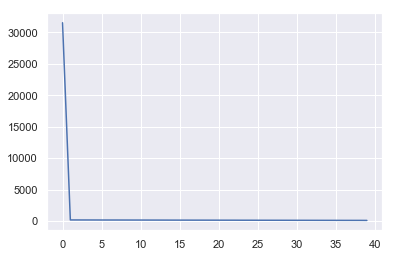

In [46]:
u,s,v = rsvd(A)
plt.plot(s)
print(s)